In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import clone_model

from dm_control import suite
from dm_control import viewer
import time

from matplotlib import pyplot as plt

In [2]:
def convert_observation(obs):
    list1 = [i.tolist() for i in list(obs.values())]
    list2 = np.array([])
    for sublist in list1:
        list2 = np.append(list2, sublist)
    return list2.reshape([1,25])

In [3]:
# parameters and models from : https://arxiv.org/pdf/1801.00690.pdf

In [4]:
# running now:

tf.keras.backend.set_floatx('float64')

class Agent:
    def actor_loss(self,y_true,y_pred):
        return - tf.reduce_mean(y_true)
    
    def __init__(self, action_spec):
        self.memory = {
            "state":np.array([]), 
            "action":np.array([], dtype = int), 
            "reward":np.array([]),
            "new_state":np.array([]), 
            "done":np.array([])
        }
        self.batch_size=64
        self.discount_rate=0.99
        self.tau=0.001
        self.action_dim = len(action_spec.minimum)
        self.action_spec = action_spec
        self.action_bound = 1.0
        self.input_size = 25  
        self.noise_scale = 0.3
        self.action_range = 1.0
        
        self.critic_opt = tf.optimizers.Adam(1e-4)
        self.actor_opt = tf.optimizers.Adam(1e-4, clipvalue=1.0)
        

        # create critic model:
        input_obs = tf.keras.Input(shape=self.input_size, name = 'state')
        input_actions = tf.keras.Input(shape=(self.action_dim,), name = 'action')
        h = tf.keras.layers.Dense(400, activation = 'relu')(input_obs)
        tmp1 = tf.keras.layers.Dense(300, activation = 'relu')(h)
        action_abs = tf.keras.layers.Dense(300, activation = 'relu')(input_actions)
        h = tf.keras.layers.Add()([tmp1,action_abs])
        h = tf.keras.layers.Activation('relu')(h)
        pred = tf.keras.layers.Dense(1, activation = 'sigmoid')(h)
        model = tf.keras.Model(inputs=[input_obs, input_actions], outputs=pred)   
        model.compile(loss='mse', optimizer=self.critic_opt)
        self.critic_model = model

        # create actor model:
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(300, input_dim = self.input_size, activation='relu'))
        model.add(tf.keras.layers.Dense(200, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_dim, activation = "tanh"))
        model.compile(loss = self.actor_loss, optimizer=self.actor_opt)
        self.actor_model = model

        # target models:
        self.target_critic_model = clone_model(self.critic_model)
        self.target_actor_model = clone_model(self.actor_model)
 
    def sample_action(self, obs):
        action = self.actor_model.predict(obs)[0]*self.action_range
        action = action + self.noise_scale*np.random.normal(size = self.action_dim)
        action = np.clip(action, -1.0, 1.0)
        return action
           
    
    def store_info(self, obs, new_obs, action, reward, done):
        if len(self.memory["state"])>0:
            if self.memory["done"].shape[0]>1e6:
                for key in self.memory.keys():
                    self.memory[key] = self.memory[key][-int(0.9e6):]
            self.memory["state"] = np.vstack((self.memory["state"], obs))
            self.memory["new_state"] = np.vstack((self.memory["new_state"], new_obs))
            self.memory["action"] = np.vstack((self.memory["action"], action))
        else:            
            self.memory["state"] = np.array(obs)
            self.memory["new_state"] = np.array(new_obs)
            self.memory["action"] = np.array(action)
        self.memory["reward"] = np.append(self.memory["reward"], reward)
        self.memory["done"] = np.append(self.memory["done"], done)        
        
        
    def experience_replay(self):
        if self.memory["done"].shape[0]>=self.batch_size:
            # get batch
            idxs = np.random.randint(self.memory["done"].shape[0], size=self.batch_size)
            batch = {
                "state": np.squeeze(self.memory["state"][idxs]), 
                "action": np.squeeze(self.memory["action"][idxs]), 
                "reward": self.memory["reward"][idxs], 
                "new_state": np.squeeze(self.memory["new_state"][idxs]), 
                "done": self.memory["done"][idxs]
            }
            
            # replay:
            target_q = self.target_critic_model({"state":batch["new_state"], 
                                            "action": self.action_range*self.target_actor_model(batch["new_state"])})

            y = batch["reward"].reshape(self.batch_size,1) + np.multiply(target_q, 
                                                                        (self.discount_rate*(1-batch["done"])
                                                                        ).reshape(self.batch_size,1)
                                                                        ) 
            
            # update critic
            with tf.GradientTape() as tape:
                q = self.critic_model({"state": batch["state"], "action": batch["action"]})
                td_error = tf.losses.mean_squared_error(y, q)
            critic_grads = tape.gradient(td_error, self.critic_model.trainable_weights)
            self.critic_opt.apply_gradients(zip(critic_grads, self.critic_model.trainable_weights))

            
            # update actor policy
            with tf.GradientTape() as tape:
                actions_pred = self.actor_model(batch["state"])*self.action_range
                #tape.watch(actions_pred)
                q = self.critic_model({"state": batch["state"], "action": actions_pred})
                actor_loss = - tf.reduce_mean(q)
            actor_grads = tape.gradient(actor_loss, self.actor_model.trainable_weights)
            self.actor_opt.apply_gradients(zip(actor_grads, self.actor_model.trainable_weights))

                        
            # update networks
            self.critic_model.set_weights(self.tau * np.array(self.target_critic_model.get_weights()) + \
                                          (1.0-self.tau)*np.array(self.critic_model.get_weights()))
            self.actor_model.set_weights(self.tau * np.array(self.target_actor_model.get_weights()) + \
                                         (1.0-self.tau)*np.array(self.actor_model.get_weights()))
            
            self.noise_scale*=0.995


In [5]:
# new:

tf.keras.backend.set_floatx('float64')

class Agent:
    def actor_loss(self,y_true,y_pred):
        return - tf.reduce_mean(y_true)
    
    def __init__(self, action_spec):
        self.memory = {
            "state":np.array([]), 
            "action":np.array([], dtype = int), 
            "reward":np.array([]),
            "new_state":np.array([]), 
            "done":np.array([])
        }
        self.batch_size=64
        self.discount_rate=0.99
        self.tau=0.001
        self.action_dim = len(action_spec.minimum)
        self.action_spec = action_spec
        self.action_bound = 1.0
        self.input_size = 25  
        self.noise_scale = 1.0 #0.3
        self.action_range = 1.0
        
        self.critic_opt = tf.optimizers.Adam(1e-4)
        self.actor_opt = tf.optimizers.Adam(1e-4)#, clipvalue=1.0)
        

        # create critic model:
        input_obs = tf.keras.Input(shape=self.input_size, name = 'state')
        input_actions = tf.keras.Input(shape=(self.action_dim,), name = 'action')
        h = tf.keras.layers.Dense(400, activation = 'relu')(input_obs)
        tmp1 = tf.keras.layers.Dense(300, activation = 'relu')(h)
        action_abs = tf.keras.layers.Dense(300, activation = 'relu')(input_actions)
        #h = tf.keras.layers.Add()([tmp1,action_abs])
        h = tf.keras.layers.Concatenate()([tmp1,action_abs])
        h = tf.keras.layers.Activation('relu')(h)
        pred = tf.keras.layers.Dense(1, activation = 'sigmoid', 
                                     kernel_initializer=tf.random_uniform_initializer(minval=-3e-3, maxval=3e-3))(h) 
        # or linear?
        model = tf.keras.Model(inputs=[input_obs, input_actions], outputs=pred)   
        model.compile(loss='mse', optimizer=self.critic_opt)
        self.critic_model = model

        # create actor model:
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(400, input_dim = self.input_size, activation='relu'))
        model.add(tf.keras.layers.Dense(300, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_dim, activation = "tanh", 
                                        kernel_initializer=tf.random_uniform_initializer(minval=-3e-3, maxval=3e-3)))
        model.compile(loss = self.actor_loss, optimizer=self.actor_opt)
        self.actor_model = model

        # target models:
        self.target_critic_model = clone_model(self.critic_model)
        self.target_actor_model = clone_model(self.actor_model)
 
    def sample_action(self, obs):
        action = self.actor_model.predict(obs)[0]*self.action_range
        action = action + self.noise_scale*np.random.normal(size = self.action_dim)
        action = np.clip(action, -1.0, 1.0)
        return action
           
    
    def store_info(self, obs, new_obs, action, reward, done):
        if len(self.memory["state"])>0:
            if self.memory["done"].shape[0]>1e6:
                for key in self.memory.keys():
                    self.memory[key] = self.memory[key][-int(0.9e6):]
            self.memory["state"] = np.vstack((self.memory["state"], obs))
            self.memory["new_state"] = np.vstack((self.memory["new_state"], new_obs))
            self.memory["action"] = np.vstack((self.memory["action"], action))
        else:            
            self.memory["state"] = np.array(obs)
            self.memory["new_state"] = np.array(new_obs)
            self.memory["action"] = np.array(action)
        self.memory["reward"] = np.append(self.memory["reward"], reward)
        self.memory["done"] = np.append(self.memory["done"], done)        
        
        
    def experience_replay(self):
        if self.memory["done"].shape[0]>=self.batch_size:
            # get batch
            idxs = np.random.randint(self.memory["done"].shape[0], size=self.batch_size)
            batch = {
                "state": np.squeeze(self.memory["state"][idxs]), 
                "action": np.squeeze(self.memory["action"][idxs]), 
                "reward": self.memory["reward"][idxs], 
                "new_state": np.squeeze(self.memory["new_state"][idxs]), 
                "done": self.memory["done"][idxs]
            }
            
            # replay:
            target_q = self.target_critic_model({"state":batch["new_state"], 
                                            "action": self.action_range*self.target_actor_model(batch["new_state"])})

            y = batch["reward"].reshape(self.batch_size,1) + np.multiply(target_q, 
                                                                        (self.discount_rate*(1-batch["done"])
                                                                        ).reshape(self.batch_size,1)
                                                                        ) 
            
            # update critic
            with tf.GradientTape() as tape:
                q = self.critic_model({"state": batch["state"], "action": batch["action"]})
                td_error = tf.losses.mean_squared_error(y, q)
            critic_grads = tape.gradient(td_error, self.critic_model.trainable_weights)
            self.critic_opt.apply_gradients(zip(critic_grads, self.critic_model.trainable_weights))

            
            # update actor policy
            with tf.GradientTape() as tape:
                actions_pred = self.actor_model(batch["state"])*self.action_range
                #tape.watch(actions_pred)
                q = self.critic_model({"state": batch["state"], "action": actions_pred})
                actor_loss = - tf.reduce_mean(q)
            actor_grads = tape.gradient(actor_loss, self.actor_model.trainable_weights)
            self.actor_opt.apply_gradients(zip(actor_grads, self.actor_model.trainable_weights))

                        
            # update networks
            self.critic_model.set_weights(self.tau * np.array(self.target_critic_model.get_weights()) + \
                                          (1.0-self.tau)*np.array(self.critic_model.get_weights()))
            self.actor_model.set_weights(self.tau * np.array(self.target_actor_model.get_weights()) + \
                                         (1.0-self.tau)*np.array(self.actor_model.get_weights()))
            
            self.noise_scale*=0.99


In [6]:
def save_models(agent):
    agent.critic_model.save('critic_model.h5')
    agent.actor_model.save('actor_model.h5')
    agent.target_critic_model.save('target_critic_model.h5')
    agent.target_actor_model.save('target_actor_model.h5')
    
def train_model(env, n_iterations, batch_size, discount_rate):
    scores = np.array([])
    last_rewards = np.array([])
    first_rewards = np.array([])
    action_spec = env.action_spec()
    agent = Agent(action_spec)
    start = time.time()
    for iteration in range(n_iterations):       
        if iteration % 25 == 0:
            save_models(agent)
            print("{:10.3f} minutes remaining".format((time.time()-start)/60))

        time_step = env.reset()  
        obs = convert_observation(time_step.observation)

        game_score = 0
        while not time_step.last():       
            # get action:
            action = agent.sample_action(obs)
            # make action:
            time_step = env.step(action)
            new_obs = convert_observation(time_step.observation)            
            # update history:
            game_score += time_step.reward 
            agent.store_info(obs, new_obs, action, time_step.reward, 0)
            obs = new_obs
            # experience replay:
            agent.experience_replay()
            if len(first_rewards)==len(last_rewards):
                first_rewards = np.append(first_rewards, time_step.reward)

        new_obs = convert_observation(time_step.observation)   
        agent.store_info(obs, new_obs, action, time_step.reward, 1)
        agent.experience_replay()
        game_score += time_step.reward 
        
        scores = np.append(scores, game_score)
        last_rewards = np.append(last_rewards, time_step.reward)
        print("Iteration: {};   score: {:10.3f}; last_reward: {:10.3f}; first_reward: {:10.3f}".format(
            iteration, game_score, time_step.reward, first_rewards[-1]))

    save_models(agent)
    return scores, last_rewards, first_rewards, agent


In [7]:
n_iterations = 50
env = suite.load(domain_name="swimmer", task_name="swimmer6")
action_spec = env.action_spec()

scores, last_rewards, first_rewards, agent = train_model(env, n_iterations, batch_size=64, discount_rate=0.99)

     0.008 minutes remaining
Iteration: 0;   score:     16.655; last_reward:      0.016; first_reward:      0.019
Iteration: 1;   score:      8.086; last_reward:      0.008; first_reward:      0.008
Iteration: 2;   score:     80.361; last_reward:      0.078; first_reward:      0.102
Iteration: 3;   score:     39.983; last_reward:      0.040; first_reward:      0.040
Iteration: 4;   score:      8.188; last_reward:      0.008; first_reward:      0.009
Iteration: 5;   score:     39.034; last_reward:      0.039; first_reward:      0.043
Iteration: 6;   score:      8.764; last_reward:      0.009; first_reward:      0.009
Iteration: 7;   score:      8.688; last_reward:      0.009; first_reward:      0.010
Iteration: 8;   score:     21.300; last_reward:      0.021; first_reward:      0.018
Iteration: 9;   score:    572.614; last_reward:      0.605; first_reward:      0.298
Iteration: 10;   score:     11.184; last_reward:      0.011; first_reward:      0.011
Iteration: 11;   score:     19.766;

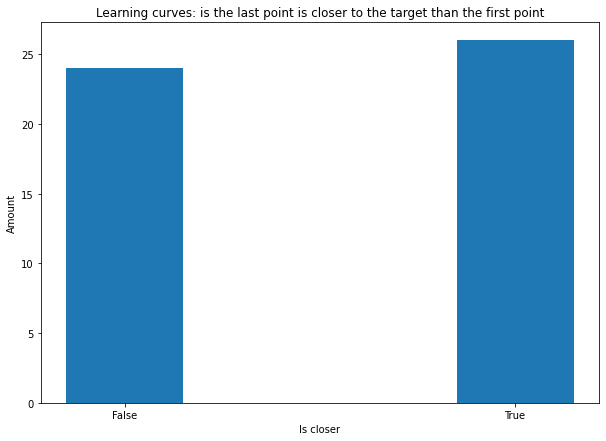

In [8]:
better_arr = np.array((last_rewards[-100:] - first_rewards[-100:])>0, dtype = int)
plt.figure(figsize=(10,7))
better_results = np.sum(better_arr)
plt.bar([0, 1],[len(better_arr)-better_results, better_results], 0.3)
plt.xticks([0,1],labels = ["False", "True"])
plt.title("Learning curves: is the last point is closer to the target than the first point")
plt.ylabel("Amount")
plt.xlabel("Is closer")
plt.savefig("closer_points.png")
plt.show()

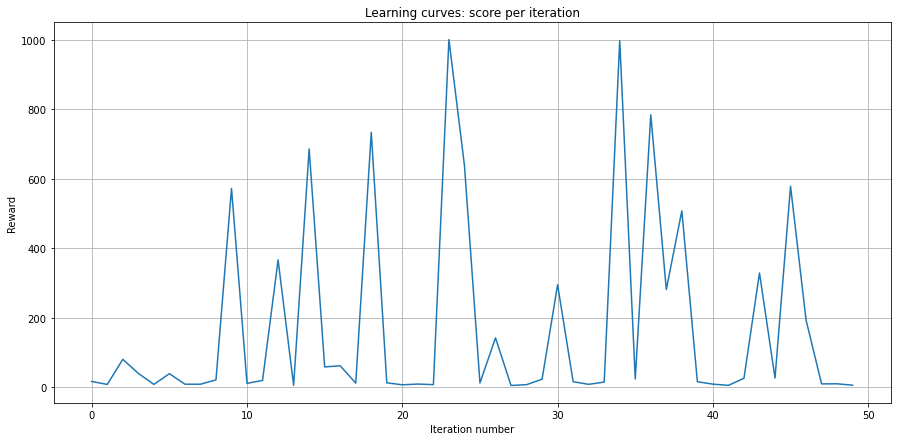

In [9]:
plt.figure(figsize=(15,7))
plt.grid()
x=list(range(len(scores)))
plt.plot(x, scores)

plt.title("Learning curves: score per iteration")
plt.ylabel("Reward")
plt.xlabel("Iteration number")
plt.savefig("learning_curves.png")
plt.show()

In [10]:
for i in range(1,2):
    print(i,"Average learning score on 100 steps: ", np.mean(scores[(i-1)*100: i*100]))

1 Average learning score on 100 steps:  175.2923023533293


In [ ]:
test_games = 100

test_scores = []
test_last_rewards = []
for game_index in range(test_games):
    score = 0
    time_step = env.reset()  
    obs = convert_observation(time_step.observation)
    while not time_step.last(): 
        action = agent.target_actor_model.predict(obs)
        time_step = env.step(action[0])
        obs = convert_observation(time_step.observation)
        score += time_step.reward

    test_scores.append(score)
    test_last_rewards.append(time_step.reward)

print("Average reward on test 100 games: ", np.mean(test_scores))

fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Reward on test 100 games')
ax.boxplot(test_scores,   
          showfliers=True)

ax.set_ylabel("Reward")
plt.savefig("rewards.png")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Rewards on the last step on test 100 games')
ax.boxplot(test_last_rewards,   
          showfliers=True)

ax.set_ylabel("Reward on the last step")
plt.savefig("last_rewards.png")
plt.show()